# Reinforcement Learning with Python: Policy Gradient

In this notebook we will train a Policy Gradient agent to solve basic grid world environment. It was taken from [Arthur Juliani](https://github.com/awjuliani/DeepRL-Agents)'s course [Simple Reinforcement Learning with Tensorflow](https://medium.com/p/8438a3e2b8df):

> In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1). At the start of each episode all squares are randomly placed within a 5x5 grid-world. The agent has 50 steps to achieve as large a reward as possible.

![GridWorld](../assets/GridWorld-v0.gif)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
import gym

from skimage import img_as_float32

import matplotlib.pyplot as plt
%matplotlib inline

from pyreinforce.brain import Brain
from pyreinforce.acting import SoftmaxPolicy
from pyreinforce.converter import Converter
from pyreinforce import PolicyGradientAgent

In order to be able to access the environment by invoking `gym.make()` method, we need to register it first

In [2]:
gym.envs.register(
    id='GridWorld-v0',
    entry_point='examples.gridworld:GridWorldEnv',
    kwargs={
        'size': 5,
        'max_episode_steps': 50
    }
)

Our `Brain` consists of three convolutional layers and one dense layer

In [3]:
# Helper function used to create convolutional layers
def conv2d(inputs, weights, biases, strides, padding):
    conv = tf.nn.conv2d(inputs, filter=weights, strides=strides, padding=padding)
    conv += biases

    return tf.nn.relu(conv)


class PolicyGradientBrain(Brain):
    def __init__(self, input_shape, n_outputs, lr, seed=None):
        super().__init__()

        tf.reset_default_graph()

        xavier_init = tf.contrib.layers.xavier_initializer(seed=seed)

        # Input layer
        self._X = tf.placeholder(tf.float32, (None,) + tuple(input_shape))

        # Convolutional layer 1
        W1 = tf.Variable(xavier_init((7, 7, 3, 32)))
        b1 = tf.Variable(xavier_init((32,)))
        conv1 = conv2d(self._X, W1, b1, strides=(1, 4, 4, 1), padding='VALID')

        # Convolutional layer 2
        W2 = tf.Variable(xavier_init((5, 5, 32, 64)))
        b2 = tf.Variable(xavier_init((64,)))
        conv2 = conv2d(conv1, W2, b2, strides=(1, 2, 2, 1), padding='VALID')

        # Convolutional layer 3
        W3 = tf.Variable(xavier_init((3, 3, 64, 128)))
        b3 = tf.Variable(xavier_init((128,)))
        conv3 = conv2d(conv2, W3, b3, strides=(1, 1, 1, 1), padding='VALID')

        # Flattened layer
        flattened = tf.reshape(conv3, (-1, 6 * 6 * 128))

        # Output layer
        W4 = tf.Variable(xavier_init((6 * 6 * 128, n_outputs)))
        b4 = tf.Variable(xavier_init((n_outputs,)))
        self._P = tf.nn.softmax(tf.matmul(flattened, W4) + b4)

        # Backpropagation
        self._A = tf.placeholder(tf.int32, (None, 1))
        A_one_hot = tf.one_hot(tf.reshape(self._A, (-1,)), n_outputs, dtype=tf.float32)
        self._G = tf.placeholder(tf.float32, (None, 1))

        score = tf.log(tf.reduce_sum(self._P * A_one_hot, axis=1, keepdims=True))
        loss = -tf.reduce_mean(score * self._G)

        optimizer = tf.train.AdamOptimizer(lr)
        self._train_op = optimizer.minimize(loss)

        self._sess = tf.Session()

    def predict_policy(self, states, **kwargs):
        if len(states.shape) < len(self._X.shape):
            states = np.expand_dims(states, axis=0)

        return self._sess.run(self._P, feed_dict={self._X: states})

    def train(self, states, actions, returns):
        self._sess.run(self._train_op, feed_dict={self._X: states, self._A: actions, self._G: returns})

    def __enter__(self):
        self._sess.__enter__()

        init = tf.global_variables_initializer()
        self._sess.run(init)

        return self

    def __exit__(self, *args):
        self._sess.__exit__(*args)

Let's pre-process states by extending abstract `Converter` class and overriding `convert_state` method

In [4]:
class GridWorldConverter(Converter):
    def convert_state(self, s):
        return img_as_float32(s)

Training parameters

In [7]:
# Seed
seed = 123

# Brain
input_shape = (84, 84, 3)
n_outputs = 4
lr = 0.00005

# Agent
n_episodes = 10000
gamma = 0.7

It's time to create and train the agent

In [8]:
env = gym.make('GridWorld-v0')
env.seed(seed)

brain = PolicyGradientBrain(input_shape, n_outputs, lr, seed)
acting = SoftmaxPolicy()
converter = GridWorldConverter()
agent = PolicyGradientAgent(n_episodes, env, brain, acting, gamma, converter)
agent.seed(seed)

with brain:
    rewards, _ = agent.run()

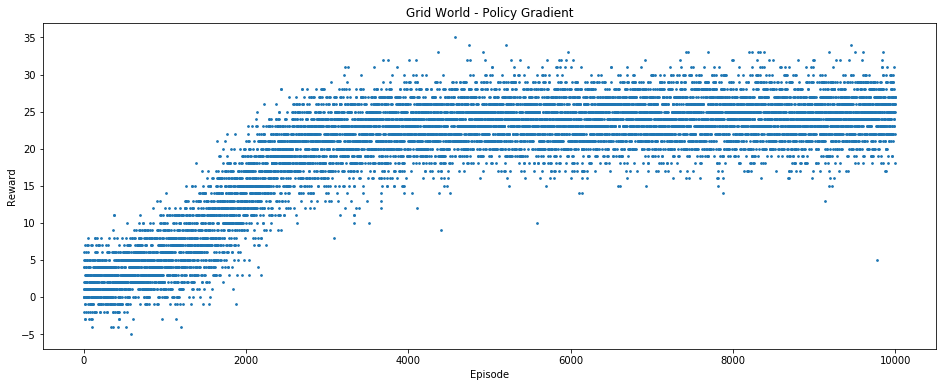

In [9]:
plt.figure(figsize=(16, 6))
plt.title('Grid World - Policy Gradient')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)

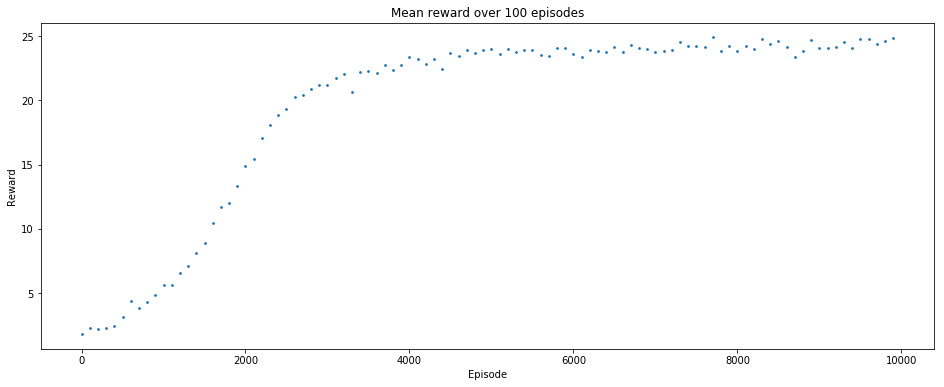

In [11]:
plt.figure(figsize=(16, 6))
plt.title('Mean reward over 100 episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(0, 10000, 100), rewards.reshape(100, 100).mean(axis=1), s=3)